# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [1]:
! wc -l data/segmented_train_seg_by_word.txt

 20000000 data/segmented_train_seg_by_word.txt


# DATA PROCESS

In [2]:
from utils import ProgressBar
import numpy as np
import collections
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
%matplotlib inline

In [3]:
enline = None
chline = None

sentlength = 4

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
with open('data/segmented_train_seg_by_word.txt') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        chlinesp = [i for i in chline.strip("\n").split()]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
            
        #if num // 2 >= 1000000:
        #    break
        

 100.00 % [==================================================>] 10000000/10000000 	 used:44s eta:0 s

In [4]:
len(enlines),len(chlines)

(150904, 150904)

In [5]:
words = []

for sent in chlines:
    for word in sent:
        words.append(word)
        
for sent in enlines:
    for word in sent:
        words.append(word)

In [6]:
from collections import Counter

In [7]:
Counter(words).most_common(15)

[('.', 69213),
 ('。', 64997),
 ('？', 18494),
 ('?', 18486),
 ('的', 15156),
 ('...', 15073),
 (',', 13814),
 ('，', 12598),
 ('the', 11865),
 ('我', 11374),
 ('！', 11165),
 ('!', 10976),
 ('i', 8885),
 ('你', 7707),
 ('了', 7633)]

In [8]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

In [9]:
word2ind = {}
ind2word = {}

specialchars = ['<pad>','<unk>']

for one in specialchars:
    addchar(word2ind,ind2word,one)

In [10]:
for word,_ in Counter(words).most_common(10000):
    addchar(word2ind,ind2word,word)

In [11]:
dat_x_in = []
dat_y = []

for chsent,ensent in zip(chlines,enlines):
    indsent = [word2ind.get(i,word2ind['<unk>']) for i in chsent]
    dat_x_in.append(indsent)
    dat_y.append(0)
    
    indsent = [word2ind.get(i,word2ind['<unk>']) for i in ensent]
    dat_x_in.append(indsent)
    dat_y.append(1)

In [12]:
dat_x_in = tf.keras.preprocessing.sequence.pad_sequences(dat_x_in,padding='post',value=word2ind['<pad>'])

In [13]:
dat_y = np.asarray(dat_y)

In [14]:
dat_x_in.shape,dat_y.shape

((301808, 4), (301808,))

In [15]:
def data_generator(batch_size):
    while True:
        for i in range(0,len(dat_x_in),batch_size):
            if i + batch_size < len(dat_x_in):
                yield dat_x_in[i:i + batch_size],dat_y[i:i + batch_size]

In [16]:
gen = data_generator(256)

In [17]:
batch_x,batch_y = gen.__next__()

In [18]:
batch_x.shape ,batch_y.shape

((256, 4), (256,))

# MODEL PART

In [19]:
batch_size = 256
embedding_size = 100
vocabulary_size = len(ind2word)
num_units = 50

In [20]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


W0927 19:05:06.555655 4665284032 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0927 19:05:06.556523 4665284032 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0927 19:05:06.564660 4665284032 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0927 19:05:06.569375 4665284032 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0927 19:05:06.574645 4665284032 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/t

In [21]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

with tf.device('/gpu:1'):
    initializer = tf.random_uniform_initializer(
        -0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    x = tf.placeholder("int32", [None, None])
    y = tf.placeholder("int32", [None])
    x_len = tf.placeholder("int32",[None])
    
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # embedding
    embedding_encoder = tf.get_variable(
        "embedding_encoder", [vocabulary_size, embedding_size],dtype=tf.float32)
    encoder_emb_inp = tf.nn.embedding_lookup(
        embedding_encoder, x)
    
    # Build RNN cell
    encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
    
    # Run Dynamic RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False,dtype=tf.float32)
    
    model_logistic = tf.layers.dense(encoder_state[0],1)
    model_pred = tf.nn.sigmoid(model_logistic)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(y,tf.float32),logits=tf.reshape(model_logistic,(-1,)))
    loss = tf.reduce_mean(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    

W0927 19:05:06.602344 4665284032 deprecation.py:323] From <ipython-input-21-b4a6faa68a16>:24: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0927 19:05:06.603173 4665284032 deprecation.py:323] From <ipython-input-21-b4a6faa68a16>:31: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0927 19:05:06.687573 4665284032 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py:738: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it

In [22]:
session.run(tf.global_variables_initializer())

In [23]:
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size)
for one_epoch in range(0,1):
    pb = ProgressBar(worksum=len(dat_x_in))
    pb.startjob()
    for one_batch in range(0,len(dat_x_in),batch_size):
        batch_x,batch_y = gen.__next__()
        batch_x_len = np.asarray([len(i) for i in batch_x])
        batch_lr = beginning_lr 
        
        _,batch_loss = session.run([optimizer,loss],feed_dict={
            x:batch_x,
            y:batch_y,
            x_len:batch_x_len,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)

EPOCH 0 batch 301568 lr 0.1 loss 0.15228311717510223 100.01 % [==================================================>] 301824/301808 	 used:20s eta:0 s

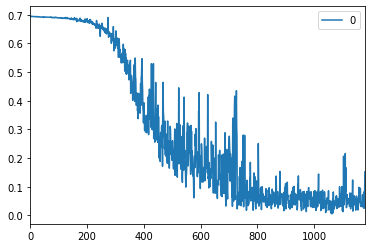

In [24]:
%matplotlib inline
pd.DataFrame(losses).plot()

# run predict

In [25]:
def predict_result(sent):
    senttoken = [word2ind[i.lower()] for i in sent.split()]
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    
    print(inputx,inputx_len)
    batch_predict = session.run(model_pred,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    return "英文" if batch_predict > 0.5 else "中文"

In [26]:
source_sentence = "who are you , what do you want ."

In [27]:
predict_result(source_sentence)

[[278  48  18   8  29 125  18 186   2]] [9]


'英文'